In [1]:
import torch 
from torch.utils import data
from torch import nn

from typing import List, Tuple, Dict, Union, Optional
from typing import Iterable

import pandas as pd
import numpy as np
import surprise

from sdv.tabular import CTGAN, GaussianCopula, CopulaGAN
import time

from tqdm.notebook import tqdm

In [2]:
import sys
import os 

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

sys.path.insert(0, r'./modules/')

In [3]:
from modules import AutoRec, Model, CollobarativeModel
from modules import get_validation_data, Dataset
from modules import nmf, svd, knn, autorec

In [4]:
SEED = 2022
CNT = 10
SAMPLE_SIZE = [0.1, 0.5, 0.9]

USERPROFILE_DATASET_PATH =  os.path.join('../..', r"data/userprofile.csv")
USERCUISINE_DATASET_PATH =  os.path.join('../..', r"data/usercuisine.csv")
CHEFMOZCUISINE_DATASET_PATH =  os.path.join('../..', r"data/chefmozcuisine.csv")
RATINGS_DATASET_PATH =  os.path.join('../..', r"data/ratings_reformatted.csv")

REAL_DATASET_SAMPLE_SIZE = 0.0229
CACHE_DIR = "./cache"

In [9]:
to_dataset = lambda x: Dataset(x, 
                  real_data.user_id.unique().shape[0], 
                  real_data.item_id.unique().shape[0], 
                  user_based=True,
                  long_matrix=True,
                  user_column="user_id", item_column="item_id", rating_column="rating")

## 1. Real restaurants data experiments

### 1.1. Data processing

In [10]:
def prepare_user_profile_df(df):
    df = df.drop(["latitude", "longitude"], axis=1)
    df = df.replace("?", pd.NA)
    df = df.fillna(method="bfill")
    return df


def prepare_user_cuisine_df(df):
    df.drop_duplicates()
    df = df.join(pd.get_dummies(df["Rcuisine"]))
    df = df.drop("Rcuisine", axis=1)
    df = df.groupby("userID").sum()
    return df


def load_and_clean_users_df():
    user_profile_df = pd.read_csv(USERPROFILE_DATASET_PATH)
    user_cuisine_df = pd.read_csv(USERCUISINE_DATASET_PATH)
    user_profile_df = prepare_user_profile_df(user_profile_df)
    user_cuisine_df = prepare_user_cuisine_df(user_cuisine_df)

    users_df = pd.merge(user_profile_df, user_cuisine_df, on="userID")
    return users_df


def load_and_prepare_rest_cuisine_df():
    df = pd.read_csv(CHEFMOZCUISINE_DATASET_PATH)
    df = df.drop_duplicates()
    df = df.join(pd.get_dummies(df["Rcuisine"]))
    df = df.drop("Rcuisine", axis=1)
    df = df.groupby("placeID").sum()
    return df



In [11]:
users_df = load_and_clean_users_df()
rests_df = load_and_prepare_rest_cuisine_df()
ratings_df = pd.read_csv(RATINGS_DATASET_PATH)

merged_df = pd.merge(ratings_df, users_df, on="userID")
merged_df = pd.merge(merged_df, rests_df, on="placeID")

rests_df['placeID'] = rests_df.index
rests_df = rests_df.reset_index(drop=True)
users_df["userID"] = users_df["userID"].astype("category").cat.codes
merged_df["userID"] = merged_df["userID"].astype("category").cat.codes
merged_df["placeID"] = merged_df["placeID"].astype("category").cat.codes

In [12]:
real_data = merged_df
real_data = real_data.rename(columns={"userID": "user_id", "placeID": "item_id"})
real_data = real_data[["user_id", "item_id", "rating"]]

real_data.rating = real_data.rating+1

### 1.2. Sparse case

In [14]:
result = pd.DataFrame()

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [ ]:
for sample in SAMPLE_SIZE:
    TRAIN, TEST = [], []
    for i in range(CNT):
        data_sparse = real_data.copy()
        data_sparse = data_sparse.sample(frac=sample)
        data_train = data_sparse.sample(frac=0.8)
        data_test = data_sparse.drop(data_train.index)


        TRAIN.append(data_train)
        TEST.append(data_test)
        
    TRAIN = list(map(to_dataset, TRAIN))
    TEST = list(map(to_dataset, TEST))
    
    print("SVD")
    print("-------------------------------------")
    svd_result = svd(TRAIN, TEST, sample, cnt=CNT)
    print("NMF")
    print("-------------------------------------")
    nmf_result = nmf(TRAIN, TEST, sample, cnt=CNT)
    print("kNN")
    print("-------------------------------------")
    knn_result = knn(TRAIN, TEST, sample, cnt=CNT)
    print("AutoRec")
    print("-------------------------------------")
    autorec_result = autorec(TRAIN, TEST, real_data, sample, cnt=CNT)
    
    result = result.append(svd_result)
    result = result.append(nmf_result)
    result = result.append(knn_result)
    result = result.append(autorec_result)

In [18]:
real_sparse = result.copy()

## 2. Synthetic restaurants data experiments

### 2.1. Generate synthetic data

In [19]:
from deeptables.models.deeptable import DeepTable, ModelConfig
from deeptables.models import deepnets
from deeptables.datasets import dsutils
from tensorflow import keras
from deeptables.models import deeptable
from sklearn.model_selection import train_test_split

In [20]:
np.random.seed(SEED)
deepFM_data = merged_df.drop(["userID", "placeID", "food_rating", "service_rating"], axis=1)
for col in deepFM_data.columns:
    deepFM_data[col] = deepFM_data[col].astype("category")
    
X, y = deepFM_data.drop("rating", axis=1), deepFM_data["rating"].astype("int64")
x_train, x_tests, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
test_results = []
net = deepnets.DeepFM
conf = ModelConfig(
    nets=net, 
    optimizer=keras.optimizers.RMSprop(),
    auto_discrete=True,
    home_dir = r'../models/tmp',
    earlystopping_patience=100,
    dnn_params={
        'dnn_activation': 'relu',
    },
)

dt = deeptable.DeepTable(config=conf)
start = time.time()
model, history = dt.fit(x_train, y_train, epochs=100, batch_size=64)
end = time.time()
print('Training of DeepFM')
print(end - start)

09-22 10:25:08 I deeptables.m.deeptable.py 335 - X.Shape=(698, 178), y.Shape=(698,), batch_size=64, config=ModelConfig(name='conf-1', nets=['dnn_nets', 'linear', 'fm_nets'], categorical_columns='auto', exclude_columns=[], task='auto', pos_label=None, metrics=['accuracy'], auto_categorize=False, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, embeddings_output_dim=4, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0, embedding_dropout=0.3, stacking_op='add', output_use_bias=True, apply_class_weight=False, optimizer=<tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x7f80de550940>, loss='auto', dnn_params={'dnn_activation': 'relu'}, autoint_params={'num_attention': 3, 'num_heads': 1, 'dropout_rate': 0, 'use_residual': True}, fg

In [22]:
score = dt.evaluate(x_tests, y_test, batch_size=64, verbose=0)
score

09-22 10:25:55 I deeptables.m.preprocessor.py 239 - Transform [X]...
09-22 10:25:55 I deeptables.m.preprocessor.py 246 - transform_X taken 0.18186092376708984s
09-22 10:25:55 I deeptables.m.preprocessor.py 227 - Transform [y]...
09-22 10:25:55 I deeptables.m.preprocessor.py 233 - transform_y taken 0.0002593994140625s
09-22 10:25:55 I deeptables.m.deepmodel.py 169 - Performing evaluation...


{'loss': 1.6189009836741857, 'accuracy': 0.50285715}

### 2.2. Similarity matrix

In [23]:
from sklearn.metrics.pairwise import cosine_similarity


def make_similarity_matrix(users_df, rests_df):
    users_food_pref_df = users_df.drop(['userID', '_merge_key'], axis=1)
    rests_food_pref_df = rests_df.drop(['placeID', '_merge_key'], axis=1)
    users_food_pref_df = users_food_pref_df[rests_food_pref_df.columns]

    sim_matrix = cosine_similarity(users_food_pref_df, rests_food_pref_df)
    sim_matrix = np.where(sim_matrix < 0.33, 1, sim_matrix)
    sim_matrix = np.where(sim_matrix >= 0.66, 3, sim_matrix)
    sim_matrix = np.where((sim_matrix >= 0.33) & (sim_matrix < 0.66), 2, sim_matrix)
    return sim_matrix

In [25]:
for i in range(1, CNT+1):
    syn_users_df = pd.read_csv(os.path.join('../..', f"./data_generators/rest_data/syn_users_df{i}.csv"))
    if "Unnamed: 0" in syn_users_df.columns:
        syn_users_df=syn_users_df.drop("Unnamed: 0", axis=1)
    if "_merge_key" in syn_users_df.columns:
        syn_users_df=syn_users_df.drop("_merge_key", axis=1)
        
    syn_items_df = pd.read_csv(os.path.join('../..', f"./data_generators/rest_data/syn_rests_df{i}.csv"))
    if "Unnamed: 0" in syn_items_df.columns:
        syn_items_df=syn_items_df.drop("Unnamed: 0", axis=1)
    if "_merge_key" in syn_items_df.columns:
        syn_items_df=syn_items_df.drop("_merge_key", axis=1)
        
    syn_users_df["_merge_key"] = syn_items_df["_merge_key"] = 1
    syn_merged_df = pd.merge(syn_users_df, syn_items_df, on="_merge_key")
    syn_merged_df = syn_merged_df.drop(["_merge_key"], axis=1)

    deepfm_syn_input = syn_merged_df.copy()
    for col in deepfm_syn_input.columns:
        deepfm_syn_input[col] = deepfm_syn_input[col].astype("category")
        
    df_resp = deepfm_syn_input.copy()
    resp = dt.predict(df_resp.drop(["userID", "placeID"], axis=1))
    
    df_resp['rating'] = resp
    df_resp = df_resp[["userID", "placeID", "rating"]].rename(columns={"userID": "user_id", "placeID": "item_id"})
    
    sim_matrix=make_similarity_matrix(syn_users_df, syn_items_df)
    
    df_resp.to_csv(os.path.join('../..', f"./synthetic_data/rest_data/matrix{i}.csv"), index=False)
    pd.DataFrame(sim_matrix).to_csv(os.path.join('../..', f"./synthetic_data/rest_data/sim{i}.csv"), index=False)

09-22 10:29:53 I deeptables.m.deeptable.py 661 - Perform prediction...
09-22 10:29:53 I deeptables.m.preprocessor.py 239 - Transform [X]...
09-22 10:29:55 I deeptables.m.preprocessor.py 246 - transform_X taken 1.55930757522583s
09-22 10:29:55 I deeptables.m.deepmodel.py 142 - Performing predictions...
09-22 10:29:56 I deeptables.m.deeptable.py 540 - predict_proba taken 2.791934013366699s
09-22 10:29:56 I deeptables.m.deeptable.py 575 - Reverse indicators to labels.
09-22 10:29:56 I deeptables.m.deeptable.py 661 - Perform prediction...
09-22 10:29:56 I deeptables.m.preprocessor.py 239 - Transform [X]...
09-22 10:29:58 I deeptables.m.preprocessor.py 246 - transform_X taken 1.5063838958740234s
09-22 10:29:58 I deeptables.m.deepmodel.py 142 - Performing predictions...
09-22 10:29:58 I deeptables.m.deeptable.py 540 - predict_proba taken 2.024373769760132s
09-22 10:29:58 I deeptables.m.deeptable.py 575 - Reverse indicators to labels.
09-22 10:29:59 I deeptables.m.deeptable.py 661 - Perform p

### 2.3. Sparse case

In [30]:
result = pd.DataFrame()

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [ ]:
for sample in SAMPLE_SIZE:
    TRAIN, TEST = [], []
    for i in range(1, CNT+1):
        syn_data = pd.read_csv(os.path.join('../..', f"./synthetic_data/rest_data/matrix{i}.csv"))
        syn_data.rating = syn_data.rating + 1
        to_dataset = lambda x: Dataset(x, 
                  syn_data.user_id.unique().shape[0], 
                  syn_data.item_id.unique().shape[0], 
                  user_based=True,
                  long_matrix=True,
                  user_column="user_id", item_column="item_id", rating_column="rating")
        
        data_sparse = syn_data.copy()
        data_sparse = data_sparse.sample(frac=frac)
        data_sparse = data_sparse.sample(frac=sample)
        data_train = data_sparse.sample(frac=0.8)
        data_test = data_sparse.drop(data_train.index)

        TRAIN.append(data_train)
        TEST.append(data_test)
    
    TRAIN = list(map(to_dataset, TRAIN))
    TEST = list(map(to_dataset, TEST))
    
    print("SVD")
    print("-------------------------------------")
    svd_result = svd(TRAIN, TEST, sample, cnt=CNT)
    print("NMF")
    print("-------------------------------------")
    nmf_result = nmf(TRAIN, TEST, sample, cnt=CNT)
    print("kNN")
    print("-------------------------------------")
    knn_result = knn(TRAIN, TEST, sample, cnt=CNT)
    print("AutoRec")
    print("-------------------------------------")
    autorec_result = autorec(TRAIN, TEST, syn_data, sample, cnt=CNT)
    
    result = result.append(svd_result)
    result = result.append(nmf_result)
    result = result.append(knn_result)
    result = result.append(autorec_result)

In [35]:
syn_sparse = result.copy()

## 3. Results

In [5]:
from modules import boxplot
names = {'SVD': 'svd', 'AutoRec': 'autorec', 'NMF': 'nmf', 'kNN': 'knn'}

In [7]:
real_sparse = real_sparse.model_name.apply(lambda x: names[x])
syn_sparse = syn_sparse.apply(lambda x: names[x])                                                              

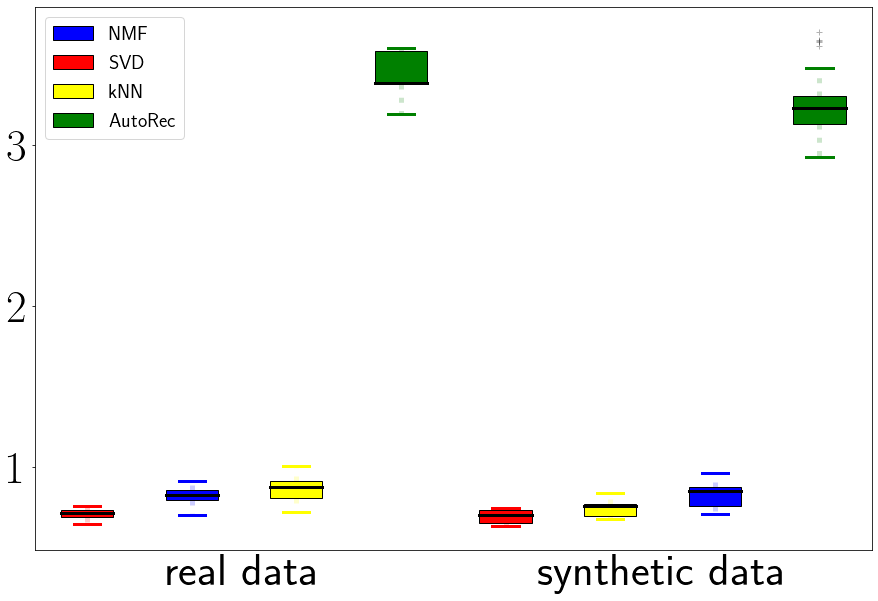

In [9]:
boxplot(real_sparse[real_sparse.sample_size == 0.5], syn_sparse[syn_sparse.sample_size == 0.5], column='rmse', legend_loc='upper left')

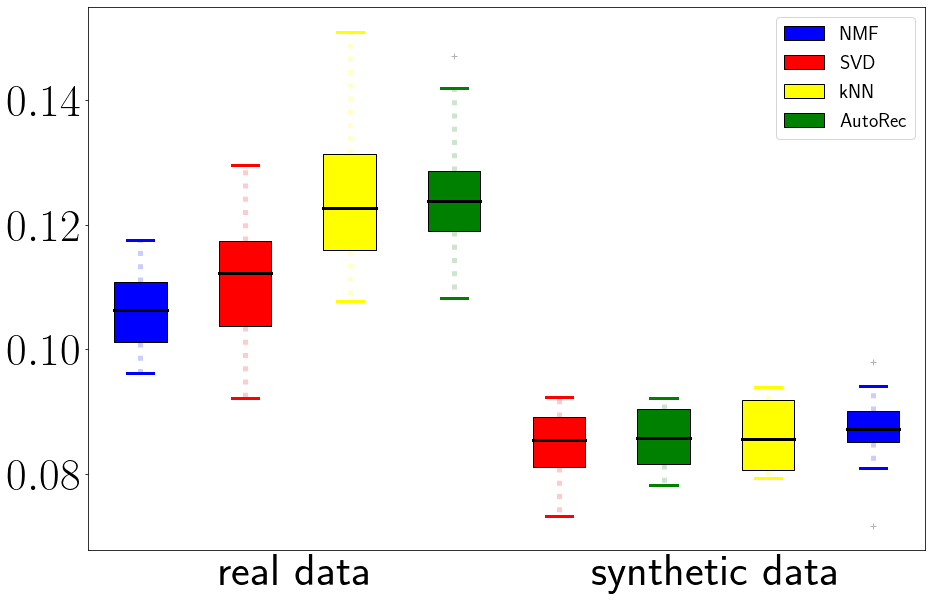

In [25]:
boxplot(real_sparse[real_sparse.sample_size == 0.5], syn_sparse[syn_sparse.sample_size == 0.5], column='ndcg', legend_loc='upper right')